<a href="https://colab.research.google.com/github/nojihun/project1/blob/main/generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os.path
import numpy as np
import imageio
import cv2
from skimage import color, io
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import scipy.ndimage as nd
from tensorflow.keras.models import Sequential, Model # <- May Use
from tensorflow.keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from skimage.transform import resize

In [2]:
drive.mount('/content/drive') # 구글 드라이브에 연동
directory1 = '/content/drive/MyDrive/captcha'

Mounted at /content/drive


In [3]:
file_list1 = os.listdir(directory1)

In [4]:
X=[] # 이 방법은 이미지를 한 글자씩으로 나누어서 각가을 학습을 시키는 것인데 문제는 이미지의 글자간의 간격이 변화하면 무쓸모가 ㅗ디낟.
y=[]

# Since there are subfolders inside the input directory, we've used nested loops
for dirname, _, filenames in os.walk(directory1):
    for filename in filenames[:10000]:
        path=os.path.join(dirname, filename) 
        
# Preprocessing the image:
# - read image
        image = cv2.imread(path,cv2.IMREAD_COLOR)


# - Blur: As in one-dimensional signals, images also can be filtered with various low-pass filters (LPF), high-pass filters (HPF), etc.
# LPF helps in removing noise, blurring images, etc. HPF filters help in finding edges in images.
        image = cv2.GaussianBlur(image, (5,5), 0)
 


# Labelling segments with the image name
        X.append(img_to_array(Image.fromarray(image)))
        y.append(path)


X=np.array(X)
y=np.array(path)

In [ ]:
y

array('/content/drive/MyDrive/captcha/AsNIw.jpg', dtype='<U40')

In [5]:

train = X
train.shape

(10000, 40, 150, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

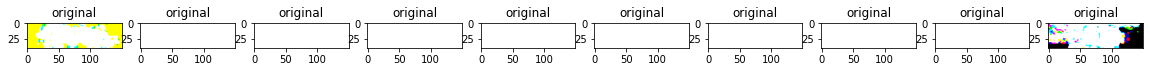

In [6]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original")
    plt.imshow((train[i]))
    plt.gray()
plt.show()

In [7]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

In [8]:
fontsize = 36
font1= ImageFont.truetype("/content/drive/MyDrive/captcha1.ttf", fontsize)
font2= ImageFont.truetype("/content/drive/MyDrive/captcha2.ttf", fontsize)
font3= ImageFont.truetype("/content/drive/MyDrive/captcha3.ttf", fontsize)
font4= ImageFont.truetype("/content/drive/MyDrive/captcha4.ttf", fontsize)
font5= ImageFont.truetype("/content/drive/MyDrive/captcha5.ttf", fontsize)
font0= ImageFont.truetype("/content/drive/MyDrive/captcha0.ttf", fontsize)
fonts = [font1, font2,font3,font4,font5,font0]

In [9]:
import random
def image_make(text):
  img = Image.open('/content/drive/MyDrive/white.jpg')
  img = img.resize((150,40))
  d1 = ImageDraw.Draw(img)
  fontsize = 36
  font = random.choice(fonts)
  d1.text((18,0 ), text, fill =(0, 0, 0), font = font)
  return img

In [10]:
label = []
for i in file_list1[:10000]:
  i = i.replace('.jpg','')
  img = image_make(i)
  img = np.array(img)
  label.append(img)


In [11]:
label = np.array(label)
label.shape

(10000, 40, 150, 3)

In [12]:
pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [13]:
import tensorflow as tf


import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
BUFFER_SIZE = 500
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [15]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image
# 이미지의 특정 부위를 랜덤하게 잘라내는 기능


# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image
#이미지의 값의 범위를 0~255가 아니라 -1~1 사이의 값으로 변경하는 기능


def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image
# 지터링, 즉 데이터 사이즈를 키워서 임의의 공간을 잘라내서 flip을 하여, 같은 이미지도 약간씩 모양이 다르도록 하여 마치 데이터 개수가 늘어난 것처럼 하는 데이터 증강 기법


def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image
# 지터링과 데이터 normalize를 동시에 적용하는 기능
def preprocess_image_test(image):
  image = normalize(image)
  return image
# 그냥 normalize만 하는 기능.


In [16]:
c_train, c_test, l_train, l_test = train_test_split(train, label, test_size=0.8)

c_trains = tf.data.Dataset.from_tensor_slices(c_train)
l_trains = tf.data.Dataset.from_tensor_slices(l_train)
c_tests = tf.data.Dataset.from_tensor_slices(c_test)
l_tests = tf.data.Dataset.from_tensor_slices(l_test)

In [17]:
c_trains = c_trains.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

l_trains = l_trains.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

c_tests = c_tests.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

l_tests = l_tests.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [18]:
sample_horse = next(iter(c_trains))
sample_zebra = next(iter(l_trains))

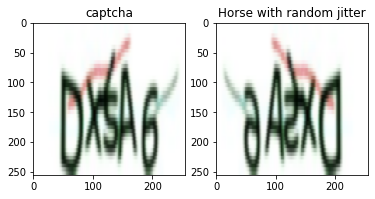

In [19]:
plt.subplot(121)
plt.title('captcha')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

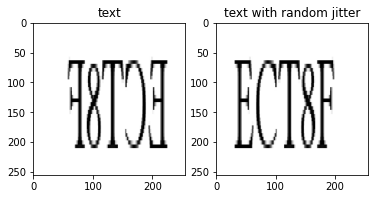

In [20]:
plt.subplot(121)
plt.title('text')
plt.imshow(sample_zebra[0] * 0.5 + 0.5 )

plt.subplot(122)
plt.title('text with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

In [21]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


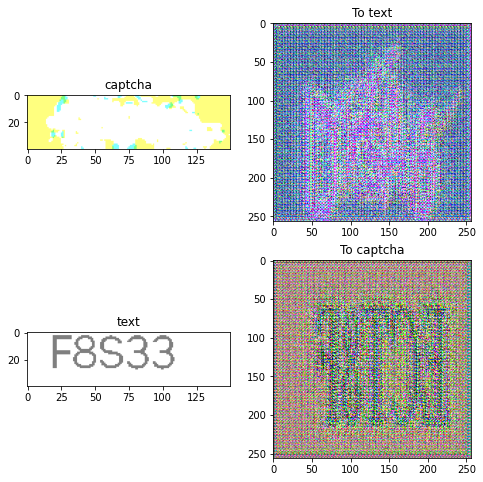

In [22]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [train, to_zebra, label, to_horse]
title = ['captcha', 'To text', 'text', 'To captcha']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

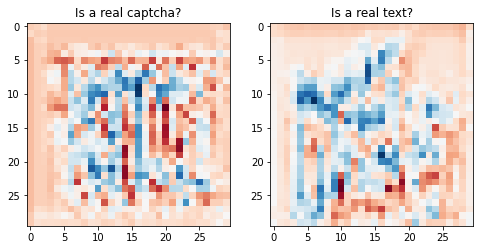

In [23]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real captcha?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real text?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [24]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
 

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)
  

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [25]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "/content/drive/MyDrive/chekpoin"


ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [26]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

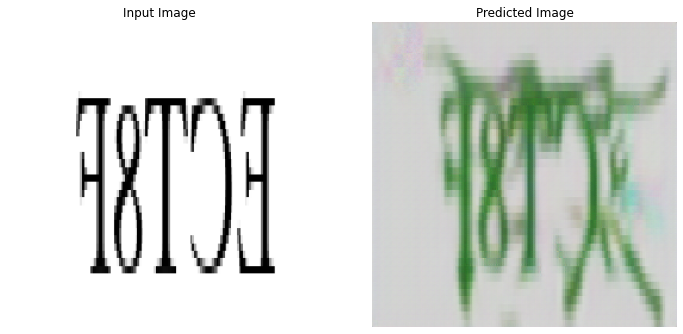

Saving checkpoint for epoch 40 at /content/drive/MyDrive/chekpoin/ckpt-10
Time taken for epoch 40 is 446.1885452270508 sec



In [27]:
EPOCHS = 40
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

 

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((l_trains, c_trains)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_zebra)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [30]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  return prediction[0]

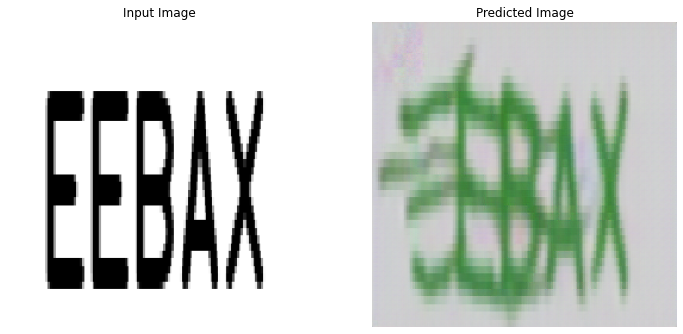

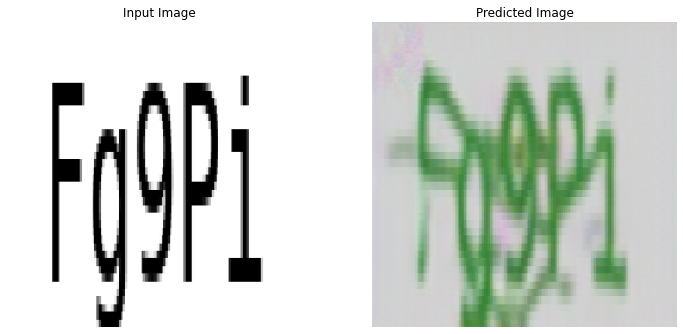

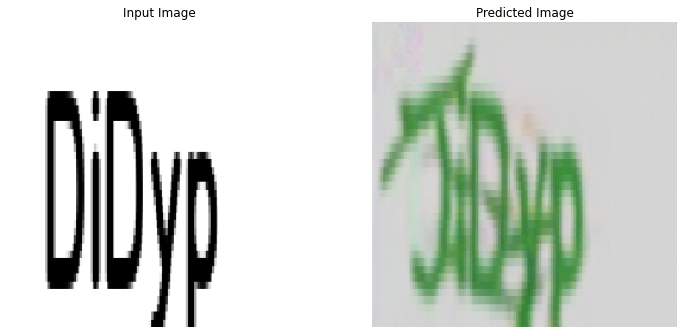

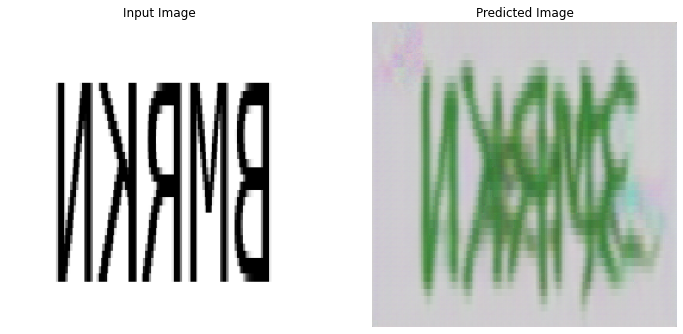

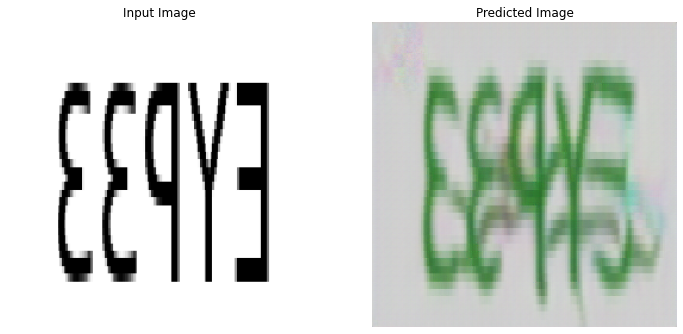

In [31]:
for inp in l_trains.take(5):
  generate_images(generator_g, inp)

In [34]:
generator_g.save('/content/drive/MyDrive','make_model.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets


In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  return prediction[0]

In [99]:
def generate_images(model, test_input):
  prediction = model(test_input)
  return prediction[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


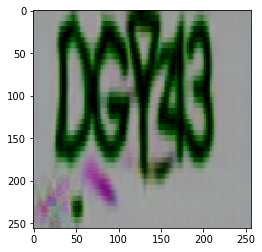

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


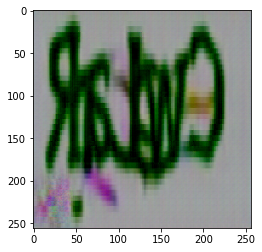

In [131]:
from PIL import Image
for inp in l_trains.take(2):
  a= generate_images(generator_g, inp)
  a_b= np.array(a)
  plt.imshow(a_b)
  plt.show()